# CARGAMOS LIBRERÍAS:

In [1]:
load("Biblioteca_GC.py")
load("Biblioteca2_GC.py")
load("Biblioteca3_GC.py")
load("Biblioteca_Voronoi.py")

# ALGORÍTMO

In [61]:
@interact
def pedirPuntos(p=slider(10,50,1,1,label='Puntos:')):
    P=[[gauss(1,2),gauss(2,1)] for i in range(p)]
    k = voronoi_main(P)
    @interact
    def pedirPaso(paso=slider(1,k,1,0, label='Paso:')):
        pasos = voronoi_main(P, paso)

Interactive function <function pedirPuntos at 0x6fc38889a60> with 1 widget
  p: TransformIntSlider(value=10, d…

In [38]:
def voronoi_main(P, interaciones = 20):
    
#     P  = [[gauss(1,2),gauss(2,1)] for i in range(32)]  # Comentar si no se quiere actualizar la nube de puntos. 

    valor_cero = 1e-9
    P1 = []
    P2 = []
    minimo = Xmin(P)[0]
    maximo = Xmax(P)[0]
    limite = [0,-50]
    cicatriz = []

    dict_cambios = {}

    h = Xmax(P)[0] - Xmin(P)[0]
    v = Ymax(P)[1] - Ymin(P)[1]
    rect = [[Xmin(P)[0]-h,Ymin(P)[1]-v],[Xmax(P)[0]+h,Ymin(P)[1]-v],[Xmax(P)[0]+h,Ymax(P)[1]+v],[Xmin(P)[0]-h,Ymax(P)[1]+v]]

    # OTRA MANERA DE INICIALIZAR EL ALGORITMO CON LOS PUNTOS p Y q INICIALES

    divisoria = [[(minimo + maximo)/2, Ymin(P)[1]], [(minimo + maximo)/2, Ymax(P)[1]]]

    for i in P:
        if areaSignada(divisoria[0], divisoria[1], i) > valor_cero:
            P1.append(i)
        else:
            P2.append(i)

    tramos = puntos_a_lo_largo_de_recta(divisoria[0], divisoria[1], 12)

    punto = tramos[0]

    # ----------------------------------------------------------------------

    
    p = Ymin(P1)
    q = Ymin(P2)

#     p = punto_mas_cercano(P1, punto)
#     q = punto_mas_cercano(P2, punto)

    med = mediatriz(p,q)
    med = redefinir_mediatriz(med, rect)
    cicatriz.append(med[0])

    dict_cambios[('p',(p[0], p[1]))] = recortePoligonoSemiplano(regionVoronoi(P1, p), med)
    dict_cambios[('q',(q[0], q[1]))] = recortePoligonoSemiplano(regionVoronoi(P2, q), (med[1], med[0])) # derecha

    # while True:
    for k in range(interaciones):  
        # Puntos inicales
        g = point(P) + line(rect + [rect[0]])
        g += point(P1, color = 'blue')
        g += point(P2, color = 'red')
        g += point(p, color = 'green', size = 50)
        g += point(q, color = 'green', size = 50)

        # Mediatriz y su representación
        med = mediatriz(p,q)
        med = redefinir_mediatriz(med, rect)
        g += line(med, color = 'orange')


        # Actualización de las regiones de Voronoi de los puntos 'p' y 'q'
        if ('p',(p[0], p[1])) in dict_cambios.keys():
    #         print(p)
            region = dict_cambios[('p',(p[0], p[1]))]
            dict_cambios[('p',(p[0], p[1]))] = recortePoligonoSemiplano(region, med)
        else:
            dict_cambios[('p',(p[0], p[1]))] = recortePoligonoSemiplano(regionVoronoi(P1, p), med)
        if ('q',(q[0], q[1])) in dict_cambios.keys():
    #         print(q)
            region = dict_cambios[('q',(q[0], q[1]))]
            dict_cambios[('q',(q[0], q[1]))] = recortePoligonoSemiplano(region, (med[1], med[0])) # derecha
        else:
            dict_cambios[('q',(q[0], q[1]))] = recortePoligonoSemiplano(regionVoronoi(P2, q), (med[1], med[0])) # derecha


        # Regiones de Voronoi de los 'p' y 'q' actuales 
        g += polygon(regionVoronoi(P1, p), color = 'blue', alpha = 0.3)
        g += polygon(regionVoronoi(P2, q), color = 'red', alpha = 0.3)

        # Hallamos puntos de intersección con las respectivas regiones
        pc1 = interseccion_recta_poligono(regionVoronoi(P1, p), med)
        pc2 = interseccion_recta_poligono(regionVoronoi(P2, q), med)

        # Eliminamos cortes ilegales que representan bordes
        pc1, pc2 = limpiar_diccionarios(pc1,pc2)

        # Cortes de mediatriz y sus representaciones
    #     print('pc1', pc1)
    #     print('pc2', pc2)
    #     for i, j in pc1.items():
    #         g += point(i, color='black')
    #         g += line(j, color='black')



    #     for i, j in pc2.items():
    #         g += point(i, color='black')
    #         g += line(j, color='black')

        # Elegimos el punto de corte con menor ordenada pero mayor que la del corte anterior
        cambio, punto_corte = decidir_cambio(pc1,pc2, limite)
    #     print(punto_corte)

    #     print(f'Iteración: {k+1}: Cambiamos el punto {cambio}.')

        # Comprobar si el algoritmo ha terminado:

        if punto_corte == None or k + 1 == interaciones: 
            
            cicatriz.append(med[1])
            
            # g = Representación con pasos
            # g_final = Representación final de cicatriz 
            g += line(cicatriz, color = 'green', thickness = 2)

            if k + 1 == interaciones:
                g.show(figsize = (15,10))
                return

            # Representación final
            g_final = point(P1, color = 'blue', size = 25)
            g_final += point(P2, color = 'red', size = 25)
            g_final += line(cicatriz, color = 'green', thickness = 3)

            g_final.show(figsize = (15,10))
            
            # Última representación con las regiones actualizadas
            g2 = point(P) + line(rect + [rect[0]])
            g2 += point(P1, color = 'blue')
            g2 += point(P2, color = 'red')
            g2 += line(cicatriz, color = 'green', thickness = 2)


            # Resultados de las Regiones de Voronoi cortadas por la mediatriz
            for clave, valor in dict_cambios.items():
                if clave[0] == 'p':
                    g2 += point(clave[1], color = 'orange')
                    g2 += polygon(valor, color = 'blue', alpha = 0.3)
                    g2 += line(valor + [valor[0]], color = 'blue', alpha = 0.7)
                if clave[0] == 'q':
                    g2 += point(clave[1], color = 'orange')
                    g2 += polygon(valor, color = 'red', alpha = 0.3)
                    g2 += line(valor + [valor[0]], color = 'red', alpha = 0.7)

            g2.show(figsize = (15,10))
            return k + 1

        # Actualizamos vecinos y formamos cicatriz con el punto de corte actual
        limite = punto_corte
        cicatriz.append(punto_corte)
        if cambio == 'p':
            p = encontrar_vecino(punto_corte,rect,P1,p)
        if cambio == 'q':
            q = encontrar_vecino(punto_corte,rect,P2,q)

        g += point(punto_corte, color = 'green')
        g += line(cicatriz, color = 'green', thickness = 2)


    #     g.show(figsize = (15,10))

## Reestructura de Diagrama de Voronoi

#### Región P1:

In [8]:
voronoi_main(P)

NameError: name 'P' is not defined

In [21]:
g = line(cicatriz, color = 'green')
for i, j in dict_cambios.items():
    if i[0] == 'p':
        g += point(i[1], color = 'blue')
        g += polygon(regionVoronoi(P1, i[1]),color = 'blue', alpha = 0.3)
        g += line(regionVoronoi(P1, i[1]) + [regionVoronoi(P1, i[1])[0]], color = 'blue')
        
        g += polygon(dict_cambios[i],color = 'orange', alpha = 0.3)

    if i[0] == 'q':
        g += point(i[1], color = 'red')
#         g += polygon(regionVoronoi(P2, i[1]),color = 'red', alpha = 0.3)
#         g += line(regionVoronoi(P2, i[1]) + [regionVoronoi(P2, i[1])[0]], color = 'red')


g.show(figsize = (15,10))


NameError: name 'cicatriz' is not defined

#### Región P2:

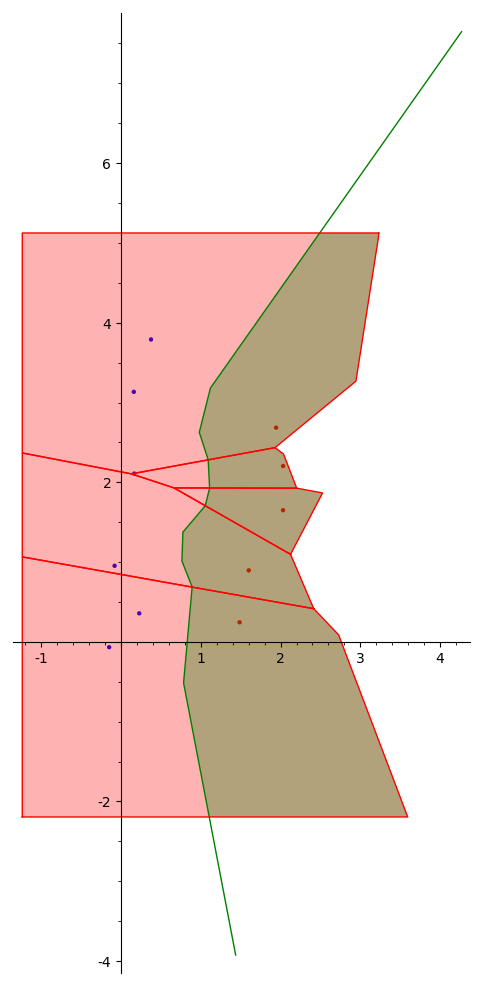

In [140]:
g = line(cicatriz, color = 'green')
for i, j in dict_cambios.items():
    if i[0] == 'p':
        g += point(i[1], color = 'blue')
#         g += polygon(regionVoronoi(P1, i[1]),color = 'blue', alpha = 0.3)
#         g += line(regionVoronoi(P1, i[1]) + [regionVoronoi(P1, i[1])[0]], color = 'blue')
#         g += polygon(dict_cambios[i],color = 'orange', alpha = 0.3)

    if i[0] == 'q':
        g += point(i[1], color = 'red')
        g += polygon(regionVoronoi(P2, i[1]),color = 'red', alpha = 0.3)
        g += line(regionVoronoi(P2, i[1]) + [regionVoronoi(P2, i[1])[0]], color = 'red')
        g += polygon(dict_cambios[i],color = 'green', alpha = 0.3)
    
g.show(figsize = (15,10))

# Representaciones:

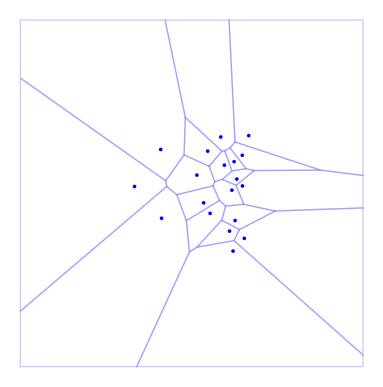

In [141]:
dibujaVoronoi(P1, 'blue')

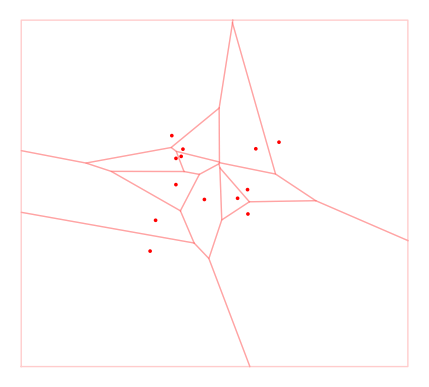

In [142]:
dibujaVoronoi(P2, 'red')

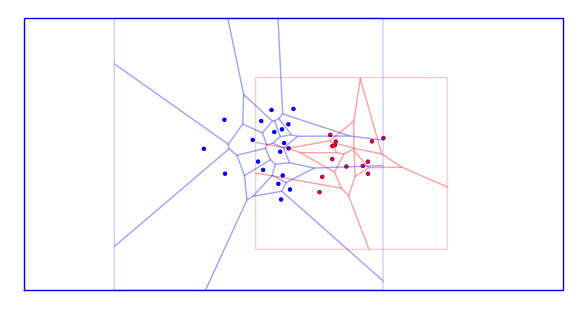

In [145]:
g3 = points(P)
g3 += dibujaVoronoi(P1,'blue', 0)
g3 += dibujaVoronoi(P2,'red', 0)
g3 += line(rect + [rect[0]])

g3.show()